In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the dataset
data = pd.read_excel('data/energy.xlsx')

# Split the data into features (X) and target (y)


X = data.drop(columns=['Qe'])
X1 = data[['T20', 'phi', 'COP', 'mu', 'effd', 'effa']]
y = data['Qe']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Check the shapes of the training and testing sets
print(X_train_lstm.shape, X_test_lstm.shape, y_train.shape, y_test.shape)


(7008, 1, 9) (1752, 1, 9) (7008,) (1752,)


In [3]:
# Define the LSTM model structure
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25, activation='relu'))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [4]:
# Define a custom callback to print loss and accuracy per epoch
print_epoch_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(
        f"Epoch {epoch+1}: Loss = {logs['loss']:.4f}, MAE = {logs['mae']:.4f}, "
        f"Val Loss = {logs['val_loss']:.4f}, Val MAE = {logs['val_mae']:.4f}"
    )
)

# Train the model with the custom callback
history_lstm = lstm_model.fit(
    X_train_lstm, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0,
    callbacks=[print_epoch_callback]
)


Epoch 1: Loss = 0.0103, MAE = 0.0449, Val Loss = 0.0004, Val MAE = 0.0096
Epoch 2: Loss = 0.0002, MAE = 0.0054, Val Loss = 0.0002, Val MAE = 0.0043
Epoch 3: Loss = 0.0001, MAE = 0.0035, Val Loss = 0.0002, Val MAE = 0.0020
Epoch 4: Loss = 0.0001, MAE = 0.0043, Val Loss = 0.0002, Val MAE = 0.0023
Epoch 5: Loss = 0.0001, MAE = 0.0042, Val Loss = 0.0003, Val MAE = 0.0097
Epoch 6: Loss = 0.0001, MAE = 0.0037, Val Loss = 0.0002, Val MAE = 0.0038
Epoch 7: Loss = 0.0001, MAE = 0.0040, Val Loss = 0.0002, Val MAE = 0.0033
Epoch 8: Loss = 0.0001, MAE = 0.0044, Val Loss = 0.0002, Val MAE = 0.0032
Epoch 9: Loss = 0.0001, MAE = 0.0040, Val Loss = 0.0003, Val MAE = 0.0097
Epoch 10: Loss = 0.0001, MAE = 0.0036, Val Loss = 0.0005, Val MAE = 0.0119
Epoch 11: Loss = 0.0001, MAE = 0.0042, Val Loss = 0.0001, Val MAE = 0.0028
Epoch 12: Loss = 0.0001, MAE = 0.0041, Val Loss = 0.0001, Val MAE = 0.0016
Epoch 13: Loss = 0.0001, MAE = 0.0032, Val Loss = 0.0003, Val MAE = 0.0093
Epoch 14: Loss = 0.0001, MAE = 0.0

In [5]:
# Save the model
lstm_model.save('models/lstm_model-M3.h5')


In [6]:
# Evaluate the model
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_train_pred_lstm = lstm_model.predict(X_train_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
print(f'MSE: {mse_lstm}, R²: {r2_lstm}')


219/219 [==============================] - 0s 2ms/step
MSE: 0.00010553457279865865, R²: 0.9988487628237662


In [7]:
# Import required metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Evaluate the model
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_train_pred_lstm = lstm_model.predict(X_train_lstm)

# Calculate R (correlation coefficient)
correlation_matrix = np.corrcoef(y_test, y_pred_lstm.flatten())
R_lstm = correlation_matrix[0, 1]

# Calculate R²
r2_lstm = r2_score(y_test, y_pred_lstm)

# Calculate MSE
mse_lstm = mean_squared_error(y_test, y_pred_lstm)

# Calculate RMSE
rmse_lstm = np.sqrt(mse_lstm)

# Calculate MAE
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)




# Print the evaluation results
print(f'R (Correlation coefficient): {R_lstm:.4f}')
print(f'R²: {r2_lstm:.4f}')
print(f'MSE: {mse_lstm:.4f}')
print(f'RMSE: {rmse_lstm:.4f}')
print(f'MAE: {mae_lstm:.4f}')


219/219 [==============================] - 0s 2ms/step
R (Correlation coefficient): 0.9994
R²: 0.9988
MSE: 0.0001
RMSE: 0.0103
MAE: 0.0011


C:\Users\binwa\AppData\Local\Temp\ipykernel_41008\3500659976.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="coolwarm")


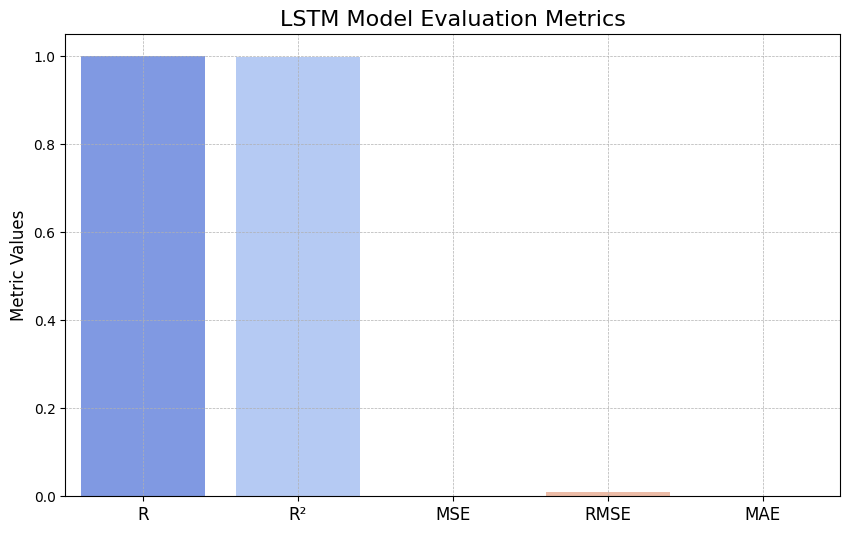

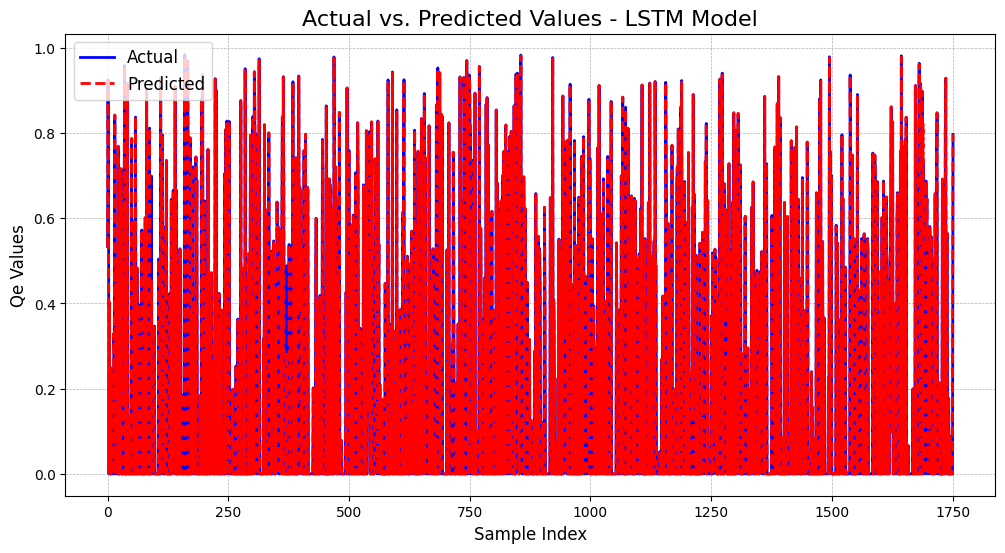

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the metrics
metrics = ['R', 'R²', 'MSE', 'RMSE', 'MAE']
values = [R_lstm, r2_lstm, mse_lstm, rmse_lstm, mae_lstm]

# Set up the figure for the metrics bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.title('LSTM Model Evaluation Metrics', fontsize=16)
plt.ylabel('Metric Values', fontsize=12)
plt.xticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot
plt.savefig('results/m3lstm_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Line plot: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_lstm.flatten(), label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Values - LSTM Model', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Qe Values', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot
plt.savefig('results/m3lstm_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# Export actual vs. predicted values to CSV and Excel files
results_lstm = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lstm.flatten()})
train_results_lstm = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred_lstm.flatten()})


# Save to Excel
results_lstm.to_excel('results/M3_actual_vs_predicted_lstm_test.xlsx', index=False)
train_results_lstm.to_excel('results/M3_actual_vs_predicted_lstm_train.xlsx', index=False) 

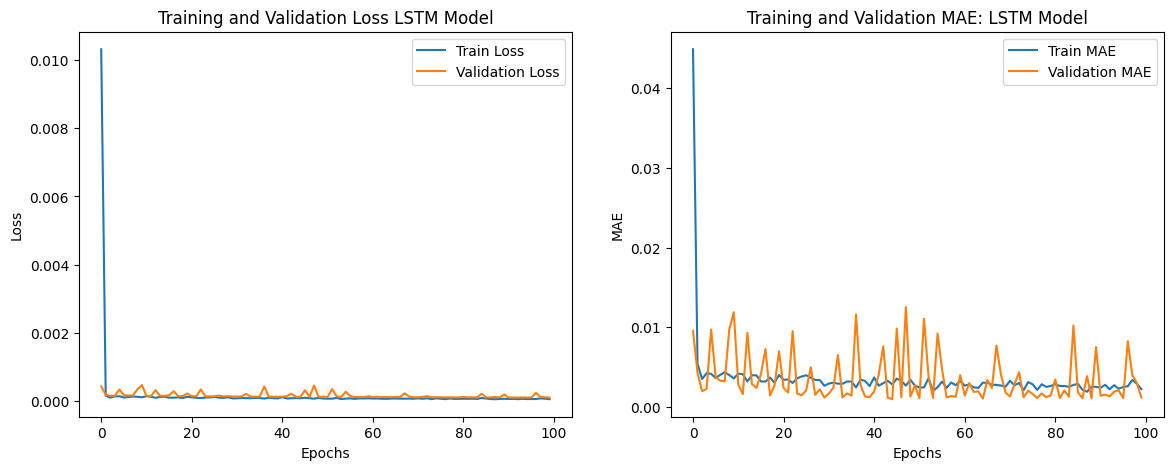

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

# Plot training loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss LSTM Model')

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE: LSTM Model') 

plt.show()
plt.savefig('results/m3training_validation_lstm.png')


In [11]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print(f'Mean Absolute Error: {mae_lstm}')


Mean Absolute Error: 0.0011290549761242554


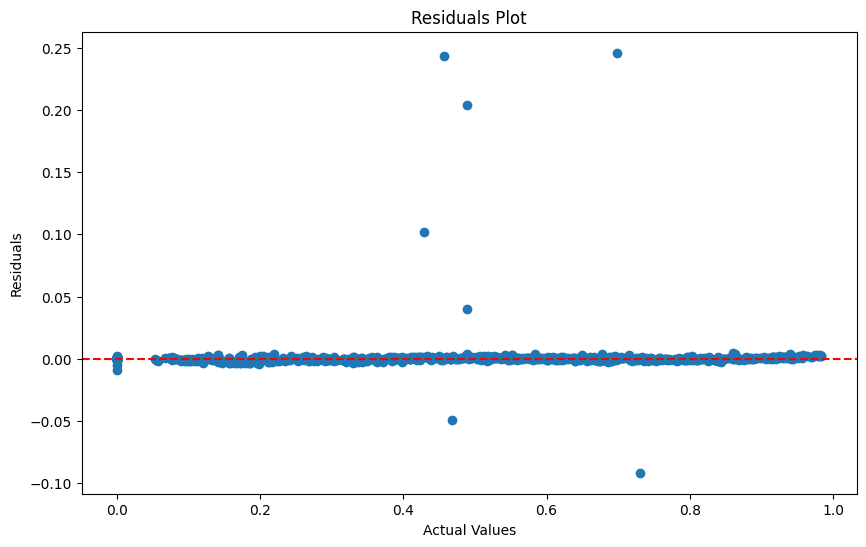

In [12]:
# Plot residuals
import matplotlib.pyplot as plt
residuals_lstm = y_test - y_pred_lstm.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_lstm)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()
